<a href="https://colab.research.google.com/github/hideaki-kyutech/softcomp2023/blob/main/FNN_classification2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hideaki-kyutech/softcomp2023/blob/main/FNN_classification2023.ipynb)

# フィードフォワードニューラルネットワーク
入力層、隠れ層、出力層の間の接続が全結合の構造をとる多層パーセプトロンモデルの例題です。

## 準備
### モジュールのインポート
torchはPyTorchというニューラルネットのための代表的なPythonモジュールの1つです。torchvisionは画像を使うニューラルネットワークの学習用のモジュールで、torchと併用して用いられます。

In [1]:
import torch
import torch.nn as nn
import torchvision # MNIST dataset etc.
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

## データセットのロード
torchvisionに含まれるMNISTという手書き数字のデータセットをロードします。trainオプションをTrueと設定しているので、学習用データセットを指定していることになります。

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='.', # where we specify the file path we want to download the data to
    train=True,
    transform=transforms.ToTensor(),
    download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 83690388.59it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114063741.83it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30674038.41it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18160656.59it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



train_datasetのdata属性を確認します。配列が入れ子になっていることと値が0ばかりであることが確認できます。また、データ型はtorch.uint8であることが確認できます。

In [3]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

train_dataset.dataの最大値を確認します。255であることがわかります。

In [4]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

train_dataset.dataの配列形状を確認します。$60000\times 28\times 28$であることが確認できます。これは1つのデータは$28\times 28$の画像で、それが60000個あることを示しています。

In [5]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

train_datasetのtargets属性を確認します。これは各データがどの数字なのかを表している教師ラベルであることが確認できます。

In [6]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

テスト用データをロードします。trainオプションがFalseとなっており、テスト用であることを示しています。サイズが$10000\times 28\times 28$であることから、10000枚の画像がテストデータとしてロードされたことがわかります。

In [7]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)
test_dataset.data.shape

torch.Size([10000, 28, 28])

## フィードフォワードニューラルネットワークモデルの構築
入力層(784=28x28)、隠れ層(128)、出力層(10)の３層パーセプトロンモデルを作成しています。入力層は入力される画像のサイズで決まります。出力層は0から9までの10種類の数字を仕分けるタスクであることから、10と決まります。隠れ層は任意に設定できますが、ここでは適当に128という設定にしています。

In [8]:
# Build the model = 3-layer MLP 784(28x28:#input)---128(hidden)---10(#class)
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# No need for final softmax!

## 計算デバイスの設定
GPUが使える場合にはGPUで計算させ、使用できるGPUがない場合はCPUで計算するための設定をしています。事前にColaboratoryメニューの[ランタイム]の[ランタイプのタイプを変更]を選択し、GPUを選択しておけばGPUを使用することができます。

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

## ロスとオプティマイザーの設定
分類問題なので、ロスはクロスエントロピーを使います。また、最適化方法としてAdamを使用しています。

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() # for multiple category
optimizer = torch.optim.Adam(model.parameters())

## データの分割
DataLoaderを利用して、データを128個ごとの小分けにします。この小分けにされたデータ群のことをバッチと呼び、バッチに含まれるデータ数はバッチサイズと呼びます。

In [11]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

バッチサイズを1にした場合は、次のようになります。

In [12]:
# Check out what the data loader does
# maps the values to (0, 1)
# makes the data of shape (batch size, color, height, width)
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)
for x, y in tmp_loader:
  print(x)
  print(x.shape)
  print(y.shape)
  break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

DataLoaderを使った後では、データセットの最大値が1になっていることが確認できます。

In [13]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

## 学習（パラメータの更新）
エポック数(学習回数)10で学習を行います。`backward()`で更新量を計算し、`step()`で更新を行なっています。

In [14]:
# Train the model
n_epochs = 10

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input : N x D
    inputs = inputs.view(-1, 784) # -1 means automatic adjustment, view (torch tensor) = reshape (numpy array)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # Get train loss and test loss
  train_loss = np.mean(train_loss) # a little misleading

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.4186, Test Loss: 0.2255
Epoch 2/10, Train Loss: 0.1938, Test Loss: 0.1606
Epoch 3/10, Train Loss: 0.1415, Test Loss: 0.1287
Epoch 4/10, Train Loss: 0.1097, Test Loss: 0.1038
Epoch 5/10, Train Loss: 0.0881, Test Loss: 0.0964
Epoch 6/10, Train Loss: 0.0730, Test Loss: 0.0843
Epoch 7/10, Train Loss: 0.0624, Test Loss: 0.0822
Epoch 8/10, Train Loss: 0.0530, Test Loss: 0.0782
Epoch 9/10, Train Loss: 0.0446, Test Loss: 0.0712
Epoch 10/10, Train Loss: 0.0387, Test Loss: 0.0739


## 誤差曲線のプロット

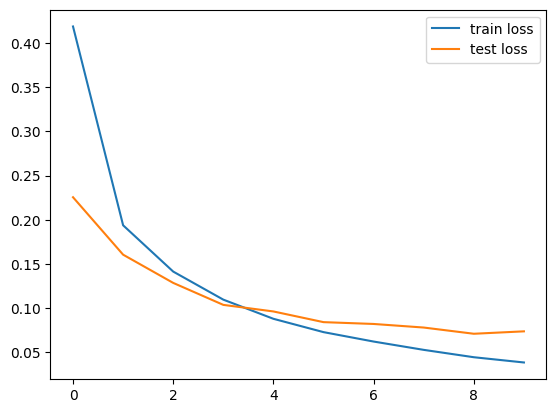

In [15]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

## 評価
学習後に、改めて学習データに対する誤差と、テストデータに対する誤差を算出しています。

In [16]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1) # _ means ignoring return value

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9910, Test acc: 0.9772


## 混同行列による結果の表示
どの数字をどの数字と間違えたのかを視覚的に見る方法に混同行列を用いた表示方法があります。


In [17]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Do these results make sense?
# It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc.

Confusion matrix, without normalization
[[ 971    0    0    1    1    0    2    1    4    0]
 [   0 1123    5    0    0    0    2    0    5    0]
 [   5    1 1009    0    1    0    2    6    8    0]
 [   0    0    8  973    0   13    0    3    7    6]
 [   1    0    4    0  964    1    5    2    2    3]
 [   2    0    0    3    1  878    2    1    4    1]
 [   5    3    0    1    1    6  938    0    4    0]
 [   0    6   12    3    0    0    0  994    5    8]
 [   4    1    2    2    3    3    2    3  953    1]
 [   3    5    0    3   13    5    0    3    8  969]]


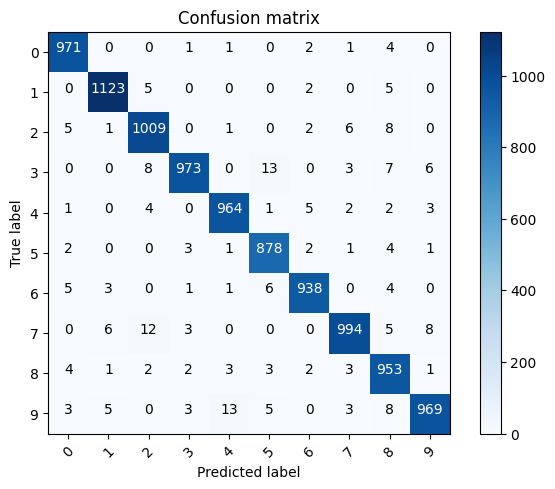

In [18]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

## 誤分類されたサンプルの表示

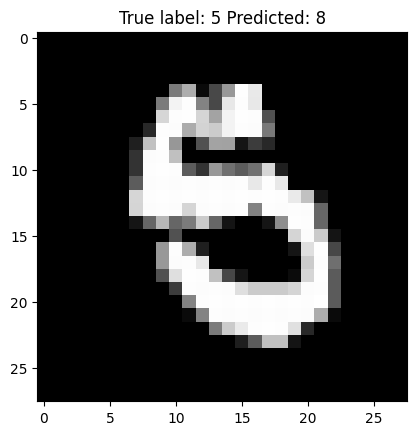

In [19]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));